# Ensemble Model (Vanilla Encoder Transformer, Vanilla LSTM with GloVe Embeddings, BERT)

#Ensemble code written by Sahil Ahuja, all other code from the following notebooks


# Referenced Notebooks:

Vanilla Encoder Transformer: https://www.kaggle.com/code/quadeer15sh/transformers-for-text-classification


Vanilla LSTM: https://www.kaggle.com/code/sharmilapolamuri/headline-sarcasm-detection-vanilla-lstm


Rohan's BERT model: https://drive.google.com/file/d/1ZKB5XUpHIZewYKa2qphGvZBCZBIzCr1G/view?usp=sharing




In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import spacy
import gensim
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.initializers import Constant


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split



In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
from plotly.offline import init_notebook_mode
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import spacy

tqdm.pandas()
spacy_eng = spacy.load("en_core_web_sm")
nltk.download('stopwords')
lemm = WordNetLemmatizer()
init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

!pip install -q transformers==4.28.0
!pip install -q evaluate
from transformers import BertTokenizer, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import evaluate

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-06-14 04:37:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-06-14 04:37:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-06-14 04:37:07--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Ensemble between Vanilla Transformer, Vanilla LSTM, and BERT (majority vote wins prediction)

In [ ]:
!unzip /content/glove.6B.zip -d "Glove"

Archive:  /content/glove.6B.zip
  inflating: Glove/glove.6B.50d.txt  
  inflating: Glove/glove.6B.100d.txt  
  inflating: Glove/glove.6B.200d.txt  
  inflating: Glove/glove.6B.300d.txt  


In [ ]:
data1 = pd.read_json('/content/Sarcasm_Headlines_Dataset_v2.json', lines=True)
df = pd.concat([data1])

In [ ]:
df.drop(columns=['article_link'], inplace=True) # Drop irrelevant columns
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


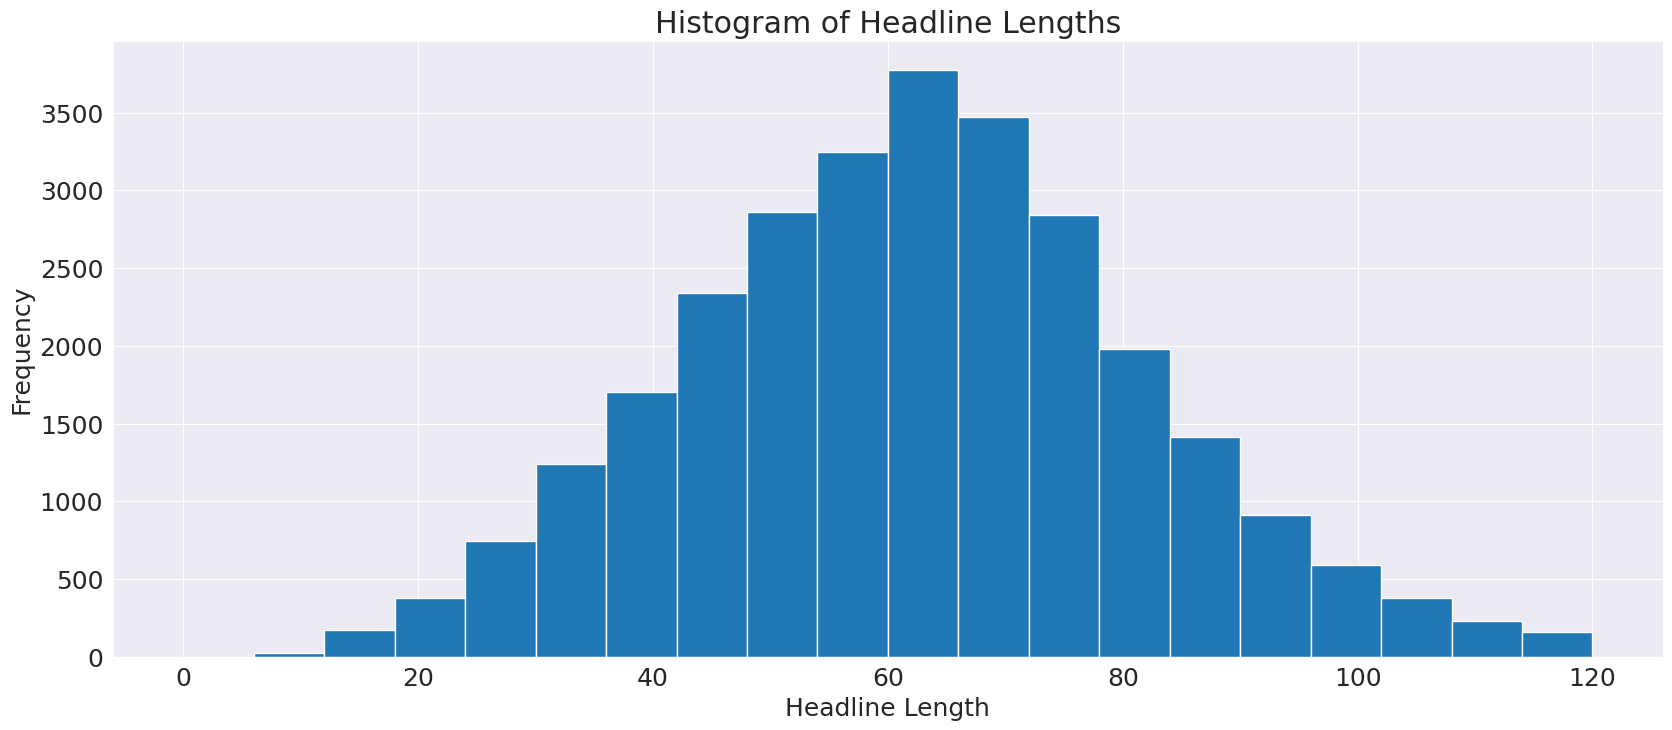

62.30857122890387

In [ ]:
df['headline_length'] = df['headline'].apply(len)
plt.hist(df['headline_length'], bins=20, range =(0, 120))  # Adjust the number of bins as per your preference
plt.xlabel('Headline Length')
plt.ylabel('Frequency')
plt.title('Histogram of Headline Lengths')
plt.show()


sum(df['headline_length'])/len(df['headline_length'])

In [ ]:
stop_words = stopwords.words('english')
stop_words.remove('not')

def text_cleaning(x):

    headline = re.sub('\s+\n+', ' ', x)
    headline = re.sub('[^a-zA-Z0-9]', ' ', x)
    headline = headline.lower()
    headline = headline.split()

    headline = [lemm.lemmatize(word, "v") for word in headline if not word in stop_words]
    headline = ' '.join(headline)

    return headline


In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#df['clean_headline'] = df['headline'].apply(text_cleaning)

In [ ]:
sentences = df['headline']
label = df['is_sarcastic']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(sentences, label, test_size=0.40, stratify=label, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, stratify=y_val, random_state=42)

X_train_orig, X_val_orig, y_train_orig, y_val_orig = X_train, X_val, y_train, y_val
X_val_orig, X_test_orig, y_val_orig, y_test_orig = X_val, X_test, y_val, y_test

In [ ]:
X_train = X_train.apply(text_cleaning)
X_val = X_val.apply(text_cleaning)

In [ ]:
print(f"Size of the Train data : {len(X_train)}")
print(f"Size of the Validation data : {len(X_val)}")
print(f"Size of the Test data : {len(X_test)}")

Size of the Train data : 17171
Size of the Validation data : 5724
Size of the Test data : 5724


In [ ]:
max_len = 25
oov_token = '00_V'
padding_type = 'post'
trunc_type = 'post'

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  17066


In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(val_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

## Checking unique words
word_index = tokenizer.word_index
print(f"Number of unique words: {len(word_index) + 1}")

Number of unique words: 17066


Vanilla Transformer (Encoder Blocks Only)

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
#embed_dim = 200
#heads = 4
#neurons = 32
#maxlen = 25
embed_dim = 200
heads = 2
neurons = 128
maxlen = 25

vocab_size = 17066

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 25)]              0         
                                                                 
 token_and_position_embeddin  (None, 25, 200)          3418200   
 g_4 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_encoder_4 (Tran  (None, 25, 200)          373728    
 sformerEncoder)                                                 
                                                                 
 global_average_pooling1d_4   (None, 200)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_14 (Dropout)        (None, 200)               0   

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 1, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=25,
                    batch_size=32,
                    callbacks=[earlystopping])

Epoch 1/25
537/537 [==============================] - 26s 41ms/step - loss: 0.5765 - accuracy: 0.6833 - val_loss: 0.4405 - val_accuracy: 0.7921
Epoch 2/25
537/537 [==============================] - 8s 15ms/step - loss: 0.3220 - accuracy: 0.8605 - val_loss: 0.4583 - val_accuracy: 0.8010
Epoch 2: early stopping


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

179/179 [==============================] - 1s 4ms/step


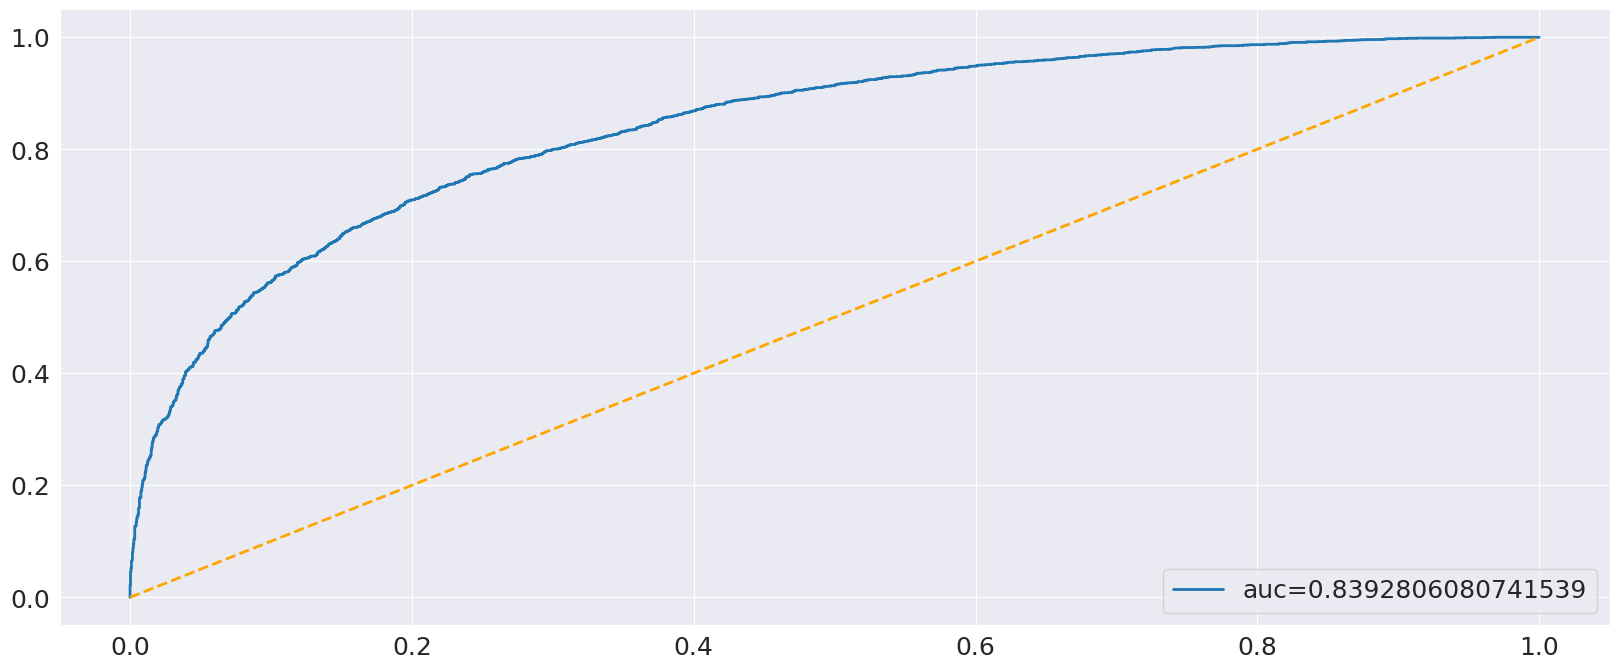

In [ ]:
y_pred_VT = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_VT)
auc = roc_auc_score(y_test, y_pred_VT)
plt.plot(fpr,tpr,label="auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()


In [ ]:
y_pred_VT[y_pred_VT>=0.80] = 1
y_pred_VT[y_pred_VT<0.80] = 0

print(classification_report(y_test, y_pred_VT))

              precision    recall  f1-score   support

           0       0.67      0.93      0.78      2997
           1       0.87      0.49      0.63      2727

    accuracy                           0.72      5724
   macro avg       0.77      0.71      0.70      5724
weighted avg       0.76      0.72      0.71      5724



Vanilla LSTM

In [ ]:
## Creating dictionary with glove words & vector values
glove_embedding = {}

with open('/content/Glove/glove.6B.100d.txt', encoding="utf-8") as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        word_vector = np.asarray(values[1:], 'float32')
        glove_embedding[word] = word_vector

glove_file.close()

## Define global variables
EMBED_DIM = 100
TOTAL_NUM_WORDS = len(word_index) + 1
MAX_SEQ_LENGTH = 25

## Creating a embedding matrix for headline words using glove wordembedding matrix
embedding_matrix = np.zeros((TOTAL_NUM_WORDS, EMBED_DIM))

for i, word in tokenizer.index_word.items():
    if i < TOTAL_NUM_WORDS:
        vector = glove_embedding.get(word)
        if vector is not None:
            embedding_matrix[i] = vector


In [ ]:

print(len(glove_embedding))

400000


In [ ]:
EMBED_DIM = 100
TOTAL_NUM_WORDS = len(word_index) + 1
MAX_SEQ_LENGTH = 25

vanilla_lstm_model = Sequential()
vanilla_lstm_model.add(Embedding(input_dim=TOTAL_NUM_WORDS,
                                 output_dim = EMBED_DIM,
                                 embeddings_initializer = Constant(embedding_matrix),
                                 input_length = MAX_SEQ_LENGTH,
                                 trainable=False))
vanilla_lstm_model.add(LSTM(100, dropout=0.3))
vanilla_lstm_model.add(Dense(1, activation='sigmoid'))

## Adding loss , optimizer and metrics to model
vanilla_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
## Train the model
history = vanilla_lstm_model.fit(X_train,
                                 y_train,
                                 epochs=30,
                                 batch_size=256,
                                 validation_data=(X_test, y_test))

Epoch 1/30
68/68 [==============================] - 3s 18ms/step - loss: 0.6230 - accuracy: 0.6545 - val_loss: 0.6221 - val_accuracy: 0.6635
Epoch 2/30
68/68 [==============================] - 1s 9ms/step - loss: 0.5690 - accuracy: 0.7062 - val_loss: 0.5795 - val_accuracy: 0.6916
Epoch 3/30
68/68 [==============================] - 1s 10ms/step - loss: 0.5351 - accuracy: 0.7319 - val_loss: 0.5346 - val_accuracy: 0.7292
Epoch 4/30
68/68 [==============================] - 1s 10ms/step - loss: 0.5061 - accuracy: 0.7506 - val_loss: 0.5350 - val_accuracy: 0.7196
Epoch 5/30
68/68 [==============================] - 1s 10ms/step - loss: 0.4727 - accuracy: 0.7704 - val_loss: 0.5471 - val_accuracy: 0.7133
Epoch 6/30
68/68 [==============================] - 1s 11ms/step - loss: 0.4568 - accuracy: 0.7844 - val_loss: 0.5207 - val_accuracy: 0.7345
Epoch 7/30
68/68 [==============================] - 1s 9ms/step - loss: 0.4415 - accuracy: 0.7955 - val_loss: 0.5905 - val_accuracy: 0.7210
Epoch 8/30
68/6

In [ ]:
## Evaluatiing model performation
y_predict_VLSTM = []
for i in vanilla_lstm_model.predict(X_test):
    if i > 0.95:
        y_predict_VLSTM.append(1)
    else:
        y_predict_VLSTM.append(0)


print(classification_report(y_test, y_predict_VLSTM))


179/179 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.60      0.99      0.75      2997
           1       0.96      0.28      0.44      2727

    accuracy                           0.65      5724
   macro avg       0.78      0.64      0.59      5724
weighted avg       0.77      0.65      0.60      5724



BERT

In [ ]:
#df = pd.read_json("/content/Sarcasm_Headlines_Dataset_v2.json", lines=True) # Read line separated json
#df.drop(columns=['article_link'], inplace=True) # Drop irrelevant columns
#df.head()

#fractions = np.array([0.6, 0.2, 0.2]) # 60% training, 20% evaluation, 20% testing
#df = df.sample(frac=1) # Shuffle the dataset
#train, val, test = np.array_split(df, (fractions[:-1].cumsum() * len(df)).astype(int))

#train = pd.DataFrame({'is_sarcastic': X_train, 'labels': y_train})
#train

In [ ]:
train = pd.DataFrame({'is_sarcastic': y_train_orig, 'headline': [arr for arr in X_train_orig]})
val = pd.DataFrame({'is_sarcastic': y_val_orig, 'headline': [arr for arr in X_val_orig]})
test = pd.DataFrame({'is_sarcastic': y_test_orig, 'headline': [arr for arr in X_test_orig]})

In [ ]:
#X_train.shape
#y_train.shape

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased") # Download the tokenizer

train_ds = Dataset.from_pandas(train.reset_index(drop=True), split="train") # Reset index after split
train_ds = train_ds.rename_column('is_sarcastic', 'labels') # Rename the target variable as specified by the Trainer class
train_ds = train_ds.map(lambda x: tokenizer(x['headline'], truncation=True, padding=True), batched=True) # Tokenize in batches

val_ds = Dataset.from_pandas(val.reset_index(drop=True), split="val")
val_ds = val_ds.rename_column('is_sarcastic', 'labels')
val_ds = val_ds.map(lambda x: tokenizer(x['headline'], truncation=True, padding=True), batched=True)

test_ds = Dataset.from_pandas(test.reset_index(drop=True), split="test")
test_ds = test_ds.rename_column('is_sarcastic', 'labels')
test_ds = test_ds.map(lambda x: tokenizer(x['headline'], truncation=True, padding=True), batched=True)

Map:   0%|          | 0/17171 [00:00<?, ? examples/s]

Map:   0%|          | 0/5724 [00:00<?, ? examples/s]

Map:   0%|          | 0/5724 [00:00<?, ? examples/s]

In [ ]:
train_ds

Dataset({
    features: ['labels', 'headline', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 17171
})

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2) # Download the model

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
args = TrainingArguments(
    output_dir = 'sarcasm_detection',   # output directory for runs
    overwrite_output_dir = True,
    evaluation_strategy = 'steps',      # evaluate after every eval_steps
    per_device_train_batch_size = 8,    # batch size for training
    per_device_eval_batch_size = 8,     # batch size for evaluation
    learning_rate = 5e-5,               # learning rate for AdamW
    num_train_epochs = 3,               # training epochs
    eval_steps = 500,                   # steps between evaluation
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy'  # preserve the most accurate model
)

In [ ]:
accuracy_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model = model,                  # model to be trained
    args = args,                    # training args
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,            # for padding batched data
    compute_metrics=compute_metrics # for custom metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy
500,0.423700,0.359004,0.863732
1000,0.364800,0.410444,0.880154
1500,0.340400,0.349057,0.897799
2000,0.332800,0.275467,0.897624
2500,0.241900,0.408522,0.907058
3000,0.189600,0.365002,0.911426
3500,0.207100,0.294183,0.913173
4000,0.182900,0.365652,0.905660
4500,0.115600,0.590222,0.903739
5000,0.062200,0.503461,0.911775


TrainOutput(global_step=6441, training_loss=0.2055613747703198, metrics={'train_runtime': 1059.2054, 'train_samples_per_second': 48.634, 'train_steps_per_second': 6.081, 'total_flos': 1704142041683820.0, 'train_loss': 0.2055613747703198, 'epoch': 3.0})

In [ ]:
bert_output = trainer.predict(test_dataset=test_ds)

In [ ]:
print(len(bert_output.predictions))
print(bert_output)

5724
PredictionOutput(predictions=array([[-2.4360693,  2.6710963],
       [-4.1409507,  4.383766 ],
       [ 4.141703 , -3.575489 ],
       ...,
       [ 1.9848342, -1.8605603],
       [-3.3316233,  3.704093 ],
       [-3.4858649,  3.8407025]], dtype=float32), label_ids=array([1, 1, 0, ..., 0, 1, 1]), metrics={'test_loss': 0.3799580931663513, 'test_accuracy': 0.9247030048916841, 'test_runtime': 29.2348, 'test_samples_per_second': 195.794, 'test_steps_per_second': 24.491})


In [ ]:
def convert_to_labels(confidence_vector):
    labels = []
    for pair in confidence_vector:
        if pair[1] > 0:
            labels.append(1)
        else:
            labels.append(0)
    return labels


y_pred_BERT = convert_to_labels(bert_output.predictions)

## Incorrect vs Correct Predictions for BERT model (predicted) (truth)

In [ ]:
count = 0
idx = 0
wrong_examples = []
for pred, truth in zip(list(bert_output.label_ids), y_pred_BERT):
    if pred != truth:
        print(test_ds['headline'][idx], pred, truth)
        wrong_examples.append(test_ds['headline'][idx])
        count += 1
    #if count == 5:
    #    break
    idx+=1

ira glass tries to explain 'this american life' at high school reunion 1 0
lincoln memorial pool to be drained after 80 ducklings die 0 1
trump, in oval office, signs first executive order on obamacare 0 1
erik estrada big in mexico 1 0
update: taylor swift back together with ex-boyfriend christopher dorner 1 0
barack obama just cracked down on wall street 0 1
long-lost salamander rediscovered in guatemalan jungle 0 1
everest avalanche victim's loved ones launch campaign dedicated to 'living life as an adventure' 0 1
sony scores big win for playstation 5 after poaching yoshi from nintendo with 10-year $400 million contract 1 0
comedy cellar holds night for male comedians to workshop sexual harassment apologies 1 0
victor hugo's les lunchables to hit broadway 1 0
voters look on in horror as 3 new republican candidates appear in place of scott walker 1 0
china tightens control over hong kong on 20th anniversary of takeover 0 1
ex-sniper shot dead after surviving years in harrowing united

In [ ]:

y_pred_VT = y_pred_VT.flatten()


print(len(y_pred_VT))
print(len(y_predict_VLSTM))
print(len(y_pred_BERT))
print(len(y_test))

5724
5724
5724
5724


In [ ]:
y_ensemble = np.add(np.add(y_pred_VT, y_predict_VLSTM), y_pred_BERT)

In [ ]:
y_pred1 = list(map(lambda x: 1 if x >= 2 else 0, y_ensemble))

In [ ]:
#use VT if it predicts 1, use BERT for predicting 0's

#if y_VT == 1 (predict true)

y_pred2 = []

for i in range(len(y_test)):
  if y_pred_VT[i] == 1 or y_pred_BERT[i] == 1 or y_predict_VLSTM == 1:
    y_pred2.append(1)
  else:
    y_pred2.append(0)
  #if y_pred_VT[i] == 1 or y_pred_BERT[i] == 0:
  #  print("hi")

print(len(y_pred2))

5724


# Ensemble Performance

In [ ]:
print(classification_report(y_test, y_pred2))
sum([(x==y) for x,y in zip(y_test, y_pred2)])/len(y_pred2)

              precision    recall  f1-score   support

           0       0.94      0.87      0.91      2997
           1       0.87      0.94      0.90      2727

    accuracy                           0.90      5724
   macro avg       0.91      0.91      0.90      5724
weighted avg       0.91      0.90      0.90      5724



0.9046121593291404

 ## Ensemble Prediction Errors (predicted) (truth)


In [ ]:
count = 0
idx = 0
for pred, truth in zip(y_test, y_pred2):
    if pred != truth:
        print(test_ds['headline'][idx], pred, truth)
        count += 1
    if count == 5:
        break
    idx+=1

ira glass tries to explain 'this american life' at high school reunion 1 0
stop fighting for overhead bin space already 0 1
lincoln memorial pool to be drained after 80 ducklings die 0 1
gunman in federal building shooting got 'raw deal': congressman 0 1
trump, in oval office, signs first executive order on obamacare 0 1


In [ ]:
print(classification_report(y_test, y_predict_VLSTM))
sum([(x==y) for x,y in zip(y_test, y_predict_VLSTM)])/len(y_test)

              precision    recall  f1-score   support

           0       0.60      0.99      0.75      2997
           1       0.96      0.28      0.44      2727

    accuracy                           0.65      5724
   macro avg       0.78      0.64      0.59      5724
weighted avg       0.77      0.65      0.60      5724



0.6535639412997903

In [ ]:
print(classification_report(y_test, y_pred_BERT))
sum([(x==y) for x,y in zip(y_test, y_pred_BERT)])/len(y_test)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2997
           1       0.92      0.92      0.92      2727

    accuracy                           0.92      5724
   macro avg       0.92      0.92      0.92      5724
weighted avg       0.92      0.92      0.92      5724



0.9247030048916841

In [ ]:
print(classification_report(y_test, y_pred_VT))
sum([(x==y) for x,y in zip(y_test, y_pred_VT)])/len(y_test)
#false positives is kept to a minimum -

              precision    recall  f1-score   support

           0       0.67      0.93      0.78      2997
           1       0.87      0.49      0.63      2727

    accuracy                           0.72      5724
   macro avg       0.77      0.71      0.70      5724
weighted avg       0.76      0.72      0.71      5724



0.7232704402515723

In [ ]:
print(classification_report(y_test, y_pred2))
sum([(x==y) for x,y in zip(y_test, y_pred2)])/len(y_test)

              precision    recall  f1-score   support

           0       0.94      0.87      0.91      2997
           1       0.87      0.94      0.90      2727

    accuracy                           0.90      5724
   macro avg       0.91      0.91      0.90      5724
weighted avg       0.91      0.90      0.90      5724



0.9046121593291404